In [ ]:
import os
import cv2 as cv
import time
import random
import warnings

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
IMG_CHANNELS = 3

In [2]:
def acc_comp(msk, preds_test_t):
    
    act = msk.reshape(len(msk),1)
    pr = preds_test_t

    c = act == pr
    d = act & pr
    e = act | pr
    neg = act.sum()
    pos = (len(act))-act.sum()

    TN = float(d.sum())
    FN = float(pr.sum()-d.sum())
    TP = float((len(act))-e.sum())
    FP = float(e.sum()-pr.sum())
    acc = float(c.sum())/(len(act))

    acc2 = float(TP+TN)/(TP+TN+FP+FN)
#     mean_TP = round(TP/pos,6)
#     mean_TN = round(TN/neg,6)
#     mean_FP = round(FP/pos,6)
#     mean_FN = round(FN/neg,6)
    
    return (acc,TP,TN,FP,FN)

In [3]:
# Define class for extracting time per epoch
class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

cb = TimingCallback() 

In [12]:
# # Dataset 1: HGR
# TRAIN_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/original_images/']
# MASK_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/skin_masks/']
# train_ids1 = next(os.walk(TRAIN_PATH1[0]))[2]
# mask_ids1 = next(os.walk(MASK_PATH1[0]))[2]
# train_ids1.sort()
# mask_ids1.sort()
# TRAIN_PATH1 = TRAIN_PATH1*len(train_ids1)
# MASK_PATH1 = MASK_PATH1*len(train_ids1)

# # Dataset 2: TDSD
# TRAIN_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/original_images/']
# MASK_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/skin_masks/']
# train_ids5 = next(os.walk(TRAIN_PATH5[0]))[2]
# mask_ids5 = next(os.walk(MASK_PATH5[0]))[2]
# train_ids5.sort()
# mask_ids5.sort()
# TRAIN_PATH5 = TRAIN_PATH5*len(train_ids5)
# MASK_PATH5 = MASK_PATH5*len(train_ids5)

# # Dataset 3: Schmugge
# TRAIN_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/original_images/']
# MASK_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/skin_masks/']
# train_ids6 = next(os.walk(TRAIN_PATH6[0]))[2]
# mask_ids6 = next(os.walk(MASK_PATH6[0]))[2]
# train_ids6.sort()
# mask_ids6.sort()
# TRAIN_PATH6 = TRAIN_PATH6*len(train_ids6)
# MASK_PATH6 = MASK_PATH6*len(train_ids6)

# # Dataset 4: Pratheepan
# TRAIN_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/original_images/']
# MASK_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
# train_ids2 = next(os.walk(TRAIN_PATH2[0]))[2]
# mask_ids2 = next(os.walk(MASK_PATH2[0]))[2]
# train_ids2.sort()
# mask_ids2.sort()
# TRAIN_PATH2 = TRAIN_PATH2*len(train_ids2)
# MASK_PATH2 = MASK_PATH2*len(train_ids2)

# # Dataset 5: VDM
# TRAIN_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/original_images/']
# MASK_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/skin_masks/']
# train_id3 = next(os.walk(TRAIN_PATH3[0]))[2]
# mask_id3 = next(os.walk(MASK_PATH3[0]))[2]
# train_id3.sort()
# mask_id3.sort()
# train_ids3 = train_id3[1:]
# mask_ids3 = mask_id3[1:]
# TRAIN_PATH3 = TRAIN_PATH3*len(train_ids3)
# MASK_PATH3 = MASK_PATH3*len(train_ids3)

# # Dataset 6: SFA
# TRAIN_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/original_images/']
# MASK_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/skin_masks/']
# train_ids4 = next(os.walk(TRAIN_PATH4[0]))[2]
# mask_ids4 = next(os.walk(MASK_PATH4[0]))[2]
# train_ids4.sort()
# mask_ids4.sort()
# TRAIN_PATH4 = TRAIN_PATH4*len(train_ids4)
# MASK_PATH4 = MASK_PATH4*len(train_ids4)

# # Dataset 7: FSD
# TRAIN_PATH7 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset7_FSD/original_images/']
# MASK_PATH7 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset7_FSD/skin_masks/']
# train_ids7 = next(os.walk(TRAIN_PATH7[0]))[2]
# mask_ids7 = next(os.walk(MASK_PATH7[0]))[2]
# train_ids7.sort()
# mask_ids7.sort()
# TRAIN_PATH7 = TRAIN_PATH7*len(train_ids7)
# MASK_PATH7 = MASK_PATH7*len(train_ids7)

# # Dataset 8: ABDOMEN
# TRAIN_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/skin_train2019/']
# MASK_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/annotations/']
# train_ids8 = next(os.walk(TRAIN_PATH8[0]))[2]
# mask_ids8 = next(os.walk(MASK_PATH8[0]))[2]
# train_ids8.sort()
# mask_ids8.sort()

# TRAIN_PATH8 = TRAIN_PATH8*len(train_ids8)
# MASK_PATH8 = MASK_PATH8*len(train_ids8)

# # Combine everything
# TRAIN_PATH = np.concatenate((TRAIN_PATH1,TRAIN_PATH2,TRAIN_PATH3,TRAIN_PATH4,TRAIN_PATH5, TRAIN_PATH6,TRAIN_PATH7,TRAIN_PATH8))
# MASK_PATH = np.concatenate((MASK_PATH1,MASK_PATH2,MASK_PATH3,MASK_PATH4,MASK_PATH5,MASK_PATH6,MASK_PATH7,MASK_PATH8))
# train_ids = np.concatenate((train_ids1,train_ids2,train_ids3,train_ids4,train_ids5,train_ids6,train_ids7,train_ids8))
# mask_ids = np.concatenate((mask_ids1,mask_ids2,mask_ids3,mask_ids4,mask_ids5,mask_ids6,mask_ids7,mask_ids8))

In [20]:
 # Extract Features and Corresponding Labels (RUN ONCE ONLY TO GET THE DATA)
print('Getting features and labels from images unreshaped... ')
sys.stdout.flush()

path = TRAIN_PATH[0] + train_ids[0]
img = imread(path)[:,:,:IMG_CHANNELS]
dat = img.reshape(img.shape[0]*img.shape[1],3)
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
lab = lab.reshape(img.shape[0]*img.shape[1],3)

path = MASK_PATH[0] + mask_ids[0]
img = imread(path)
if img.ndim == 3:
    img = img[:,:,1]   
if (np.unique(img).size) > 2:
    img = img > 30     # Important, needed to make labels 0's and 1's only 
else:
    img = img > 0
L = img.reshape(img.shape[0]*img.shape[1],1)

dat = np.concatenate((dat,hsv,lab,L),axis=1)

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH[n] + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    b = img.reshape(img.shape[0]*img.shape[1],3)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
    lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    lab = lab.reshape(img.shape[0]*img.shape[1],3)
    
    path = MASK_PATH[n] + mask_ids[n]
    img = imread(path)
    if img.ndim == 3:
        img = img[:,:,1]
        
    if (np.unique(img).size) > 2:
        img = img > 30     # Important, needed to make labels 0's and 1's only 
    else:
        img = img > 0
        
    L = img.reshape(img.shape[0]*img.shape[1],1)
    dat_temp = np.concatenate((b,hsv,lab,L),axis=1)
    dat = np.concatenate((dat,dat_temp))

ABD = dat

Getting features and labels from images unreshaped... 


100%|██████████| 756/756 [04:16<00:00,  2.10it/s]


In [21]:
# print(dat.shape)
# print(np.sum(dat[:,9]))
# np.save('VDM.npy',VDM)
# print(np.unique(dat[:,9]))

(74043165, 10)


In [22]:
# Load the data then shuffle
# ABD = np.load('ABD.npy')
np.random.shuffle(ABD)

# FSD = np.load('FSD.npy')
# FSD = FSD[:4000000]
np.random.shuffle(FSD)

# HGR = np.load('HGR.npy')
np.random.shuffle(HGR)

# Pratheep = np.load('Pratheep.npy')
# np.random.shuffle(Pratheep)

# SCHMG = np.load('SCHMG.npy')
np.random.shuffle(SCHMG)

# SFA = np.load('SFA.npy')
np.random.shuffle(SFA)

# TDSD = np.load('TDSD.npy')
np.random.shuffle(TDSD)

# VDM = np.load('VDM.npy')
np.random.shuffle(VDM)

In [25]:
# Extract and Balance Data
L=np.where(ABD[:,9] > 0)
K = L[0]
skin_abd = ABD[K[:]]
skin_abd = skin_abd[:30000]
L=np.where(ABD[:,9] == 0)
K = L[0]
noskin_abd = ABD[K[:]]
noskin_abd = noskin_abd[:70000]

# L=np.where(FSD[:,9] > 0)
# K = L[0]
# skin_fsd = FSD[K[:]]
# skin_fsd = skin_fsd[:30000]
# L=np.where(FSD[:,9] == 0)
# K = L[0]
# noskin_fsd = FSD[K[:]]
# noskin_fsd = noskin_fsd[:70000]

L=np.where(HGR[:,9] > 0)
K = L[0]
skin_hgr = HGR[K[:]]
skin_hgr = skin_hgr[:60000]
L=np.where(HGR[:,9] == 0)
K = L[0]
noskin_hgr = HGR[K[:]]
noskin_hgr = noskin_hgr[:140000]

# L=np.where(Pratheep[:,9] > 0)
# K = L[0]
# skin_pra = Pratheep[K[:]]
# skin_pra = skin_pra[:30000]
# L=np.where(Pratheep[:,9] == 0)
# K = L[0]
# noskin_pra = Pratheep[K[:]]
# noskin_pra = noskin_pra[:70000]

L=np.where(SCHMG[:,9] > 0)
K = L[0]
skin_schmg = SCHMG[K[:]]
skin_schmg = skin_schmg[:60000]
L=np.where(SCHMG[:,9] == 0)
K = L[0]
noskin_schmg = SCHMG[K[:]]
noskin_schmg = noskin_schmg[:140000]

L=np.where(SFA[:,9] > 0)
K = L[0]
skin_sfa = SFA[K[:]]
skin_sfa = skin_sfa[:60000]
L=np.where(SFA[:,9] == 0)
K = L[0]
noskin_sfa = SFA[K[:]]
noskin_sfa = noskin_sfa[:140000]

L=np.where(TDSD[:,9] > 0)
K = L[0]
skin_tdsd = TDSD[K[:]]
skin_tdsd = skin_tdsd[:60000]
L=np.where(TDSD[:,9] == 0)
K = L[0]
noskin_tdsd = TDSD[K[:]]
noskin_tdsd = noskin_tdsd[:140000]

L=np.where(VDM[:,9] > 0)
K = L[0]
skin_vdm = VDM[K[:]]
skin_vdm = skin_vdm[:60000]
L=np.where(VDM[:,9] == 0)
K = L[0]
noskin_vdm = VDM[K[:]]
noskin_vdm = noskin_vdm[:140000]

In [25]:
# Load Shuffled data
alldata = np.concatenate((ABD,FSD,HGR,VDM,SCHMG,SFA,TDSD,VDM), axis = 0)
# alldata = np.concatenate((skin_abd,skin_hgr,skin_schmg,skin_sfa,skin_tdsd,skin_vdm,noskin_abd,noskin_hgr,noskin_schmg,noskin_sfa,noskin_tdsd,noskin_vdm), axis = 0)
# np.random.shuffle(alldata)
take = alldata[:2000000]
print(take.shape)
feat = take[:,:9]
labels = take[:,9]
labels = (labels > 0).astype(np.uint8)

(2000000, 10)


In [ ]:
# Build the network
model = Sequential()
model.add(Dense(9, input_dim=9, activation='relu'))
model.add(Dropout(0.2, input_shape=(9,)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2, input_shape=(32,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2, input_shape=(64,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, input_shape=(128,)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2, input_shape=(256,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, input_shape=(128,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2, input_shape=(64,)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2, input_shape=(32,)))
model.add(Dense(9, activation='relu'))
model.add(Dropout(0.2, input_shape=(9,)))
model.add(Dense(1, activation='sigmoid'))

checkpointer = ModelCheckpoint('model-testall-26Mar2019.h5', verbose=1, save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

results = model.fit(feat, labels, validation_split=0.2, epochs=50, batch_size=64, shuffle=True, 
          callbacks=[checkpointer, cb])

Train on 1600000 samples, validate on 400000 samples
Epoch 1/50
1600000/1600000 [==============================] - 188s 117us/step - loss: 0.2445 - acc: 0.9085 - val_loss: 0.2024 - val_acc: 0.9306

Epoch 00001: val_loss improved from inf to 0.20238, saving model to model-testall-26Mar2019.h5
Epoch 2/50
1600000/1600000 [==============================] - 185s 116us/step - loss: 0.2239 - acc: 0.9201 - val_loss: 0.2166 - val_acc: 0.9324

Epoch 00002: val_loss did not improve from 0.20238
Epoch 3/50
1600000/1600000 [==============================] - 185s 116us/step - loss: 0.2236 - acc: 0.9212 - val_loss: 0.2143 - val_acc: 0.9321

Epoch 00003: val_loss did not improve from 0.20238
Epoch 4/50
1600000/1600000 [==============================] - 184s 115us/step - loss: 0.2214 - acc: 0.9218 - val_loss: 0.2387 - val_acc: 0.9336

Epoch 00004: val_loss did not improve from 0.20238
Epoch 5/50
1600000/1600000 [==============================] - 185s 115us/step - loss: 0.2213 - acc: 0.9225 - val_loss: 

In [ ]:
#print(results.history.keys())

# Summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for mean_iou
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Results and Plots
# model.summary()
print("UNET ARCHITECTURE")
print ("-------------------------------------------------------------")
print("Total num of training images: %d" % len(train_ids))
print("Max num of epochs: %d" % 50)
print("Optimizer: %s" % 'ADAM')
print("Batch size: %d" % 64)
print("Loss function: %s" % 'Binary Cross-Entropy')
print("Validation data percentage: %d" % 10)
print("Early stoppping: %s" % 'Yes')

ep = 50;
a = results.history["acc"]
b = results.history["loss"]
c = results.history["val_acc"]
d = results.history["val_loss"]
e = cb.times
print ("-------------------------------------------------------------")
header = "#"+"    "+"Time sec"+"      "+"Tr_acc"+"     "+"Tr_loss"+"      "+"Vl_acc"+"     "+"Vl_loss"
print(header)
print ("-------------------------------------------------------------")
for l in range(ep):
    str = "%d\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f" % (l, round(e[l],4),round(a[l],4),round(b[l],4),round(c[l],4),d[l])
    print (str.expandtabs(2))
print ("-------------------------------------------------------------")

In [68]:
# Evaluate the model
model = load_model('model-testall-26Mar2019.h5')
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Compute Accuracy for Abdomen Set
ABD_PATH = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/original_images/']
MSK_PATH = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
# abd_ids = next(os.walk(TRAIN_PATH2[0]))[2]
# msk_ids = next(os.walk(MASK_PATH2[0]))[2]
# abd_ids.sort()
# msk_ids.sort()
# ABD_PATH = ABD_PATH*len(abd_ids)
# MSK_PATH = MSK_PATH*len(msk_ids)

# ABD_PATH = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset7_SFA/original_images/']
# MSK_PATH = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset7_SFA/skin_masks/']

ABD_PATH = TRAIN_PATH8
MSK_PATH = MASK_PATH8
abd_ids = next(os.walk(ABD_PATH[0]))[2]
msk_ids = next(os.walk(MSK_PATH[0]))[2]
abd_ids.sort()
msk_ids.sort()
abd_ids = abd_ids[-100:]
msk_ids = msk_ids[-100:]

print('Getting features and labels from images unreshaped... ')
sys.stdout.flush()

path = ABD_PATH[0] + abd_ids[0]
img = imread(path)[:,:,:IMG_CHANNELS]
dat = img.reshape(img.shape[0]*img.shape[1],3)
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
lab = lab.reshape(img.shape[0]*img.shape[1],3)

path = MSK_PATH[0] + msk_ids[0]
img = imread(path)

if img.ndim == 3:
    img = img[:,:,1]
    
# img = img > 30    
img = img > 0
img = img.astype(np.uint8)
L = img.reshape(img.shape[0]*img.shape[1],1)

dat = np.concatenate((dat,hsv,lab,L),axis=1)

for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH[n] + abd_ids[n]
    img = imread(path)[:,:,:IMG_CHANNELS]
    b = img.reshape(img.shape[0]*img.shape[1],3)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
    lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    lab = lab.reshape(img.shape[0]*img.shape[1],3)
    
    path = MSK_PATH[n] + msk_ids[n]
    img = imread(path)

    if img.ndim == 3:
        img = img[:,:,1]
    
#     img = img > 30    
    img = img > 0
    img = img.astype(np.uint8)
    L = img.reshape(img.shape[0]*img.shape[1],1)
    
    dat_temp = np.concatenate((b,hsv,lab,L),axis=1)
    dat = np.concatenate((dat,dat_temp))
   
X = dat[:,0:9]
Y = dat[:,9]

scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Getting features and labels from images unreshaped... 






  0%|          | 0/100 [00:00<?, ?it/s]



  7%|▋         | 7/100 [00:00<00:01, 64.18it/s]



 12%|█▏        | 12/100 [00:00<00:01, 55.84it/s]



 18%|█▊        | 18/100 [00:00<00:01, 50.77it/s]



 22%|██▏       | 22/100 [00:00<00:01, 40.08it/s]



 25%|██▌       | 25/100 [00:00<00:02, 33.66it/s]



 28%|██▊       | 28/100 [00:00<00:02, 29.57it/s]



 31%|███       | 31/100 [00:00<00:02, 27.56it/s]



 34%|███▍      | 34/100 [00:01<00:02, 25.34it/s]



 37%|███▋      | 37/100 [00:01<00:02, 23.78it/s]



 40%|████      | 40/100 [00:01<00:02, 22.02it/s]



 43%|████▎     | 43/100 [00:01<00:02, 20.53it/s]



 46%|████▌     | 46/100 [00:01<00:02, 19.59it/s]



 48%|████▊     | 48/100 [00:01<00:02, 18.65it/s]



 50%|█████     | 50/100 [00:01<00:02, 17.59it/s]



 52%|█████▏    | 52/100 [00:02<00:02, 16.78it/s]



 54%|█████▍    | 54/100 [00:02<00:02, 16.29it/s]



 56%|█████▌    | 56/100 [00:02<00:02, 15.67it/s]



 58%|█████▊    | 58/100 [00:02<00:02, 15.19it/s]



 60%|██████    | 6

18105990/18105990 [==============================] - 1670s 92us/step

acc: 81.87%


In [4]:
# scores = model.evaluate(X, Y)
# preds_test = model.predict(X, verbose=1)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)
# print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# Evaluate the model
model = load_model('model-masturbation2-11Feb2019.h5')
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Compute Accuracy for Abdomen Set
ABD_PATH = '/home/lalzogbi/Documents/Skin_Datasets/allabdomen/val/skin_val2019/'
MSK_PATH = '/home/lalzogbi/Documents/Skin_Datasets/allabdomen/val/annotations/'

# ABD_PATH = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/original_images/']
# MSK_PATH = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()
# ABD_PATH = ABD_PATH*len(abd_ids)
# MSK_PATH = MSK_PATH*len(msk_ids)
# print(len(abd_ids))

# abd_ids = abd_ids[6:]
# msk_ids = msk_ids[6:]

# Actual Predictions
# N = np.zeros((1,4))

# for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
path = ABD_PATH + abd_ids[21]
img = imread(path)[:,:,:IMG_CHANNELS]
t = img
#     img = resize(img, (128, 128), mode='constant', preserve_range=True).astype('uint8')
b = img.reshape(img.shape[0]*img.shape[1],3)

hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
lab = lab.reshape(img.shape[0]*img.shape[1],3)

path = MSK_PATH + msk_ids[21]
img = imread(path)
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                                       preserve_range=True).astype('uint8')

if img.ndim == 3:
    img = img[:,:,1]

img = img > 30    
img = img > 0
img = img.astype(np.uint8)
L = img.reshape(img.shape[0]*img.shape[1],1)
dat_temp = np.concatenate((b,hsv,lab,L),axis=1)

X = dat_temp[:,0:9]
Y = dat_temp[:,9]
    
preds_test = model.predict(X[:int(X.shape[0])], verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# answer = acc_comp(Y, preds_test_t)

# a = answer[1]
# b = answer[2]
# c = answer[3]
# d = answer[4]

# K = np.array((a,b,c,d)).reshape(1,4)
# N = np.concatenate((N,K),axis = 0)
#     print(N)

51529/51529 [==============================] - 2s 43us/step


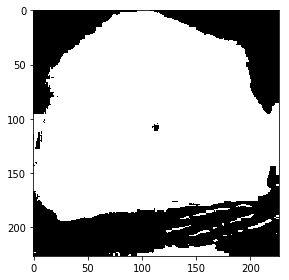

True

In [6]:
# print(preds_test_t.shape)
preds_test_t.reshape(t.shape[0],t.shape[1],1)
curly = preds_test_t.reshape(t.shape[0],t.shape[1])
imshow(curly*255)
plt.show()
cv.imwrite('darkskinFeatures.jpg',curly*255)

In [7]:
# Overall accuracy on abdomen pictures
# answer = acc_comp(Y, preds_test_t)

# a = answer[1]
# b = answer[2]
# c = answer[3]
# d = answer[4]
# K = np.array((a,b,c,d)).reshape(1,4)
# print(K.shape)

# N = np.zeros((1,4))
# N = np.concatenate((N,K),axis = 0)
out = N[1:]
j = (out[:,0]+out[:,1])/(out[:,0]+out[:,1]+out[:,2]+out[:,3])
print(np.mean(j))
np.save('pra-features.npy',out)

0.7806530469718845


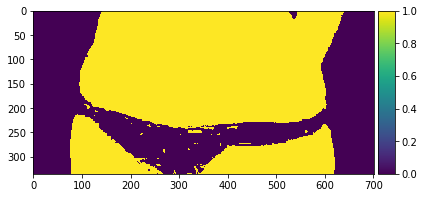

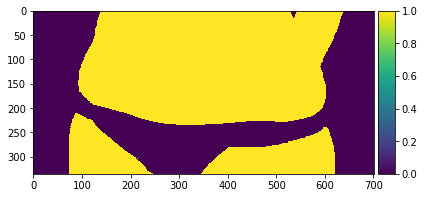

In [75]:
output = np.reshape(preds_test_t,(img.shape[0],img.shape[1]))
plt.show()
imshow(output)
plt.show()
imshow(img)

In [ ]:
feat = dat[0:800000,0:9]
labels = dat[0:800000,9]
labels = (labels > 0).astype(np.uint8)
print(feat.shape)
print(labels.shape)
X = dat[800000:,0:9]
Y = dat[800000:,9]
Y = (Y > 0).astype(np.uint8) 
print(X.shape)
print(Y.shape)